# ML Tutorial

## Machine Learning Overview

The Machine Learning (ML) enhancement pipeline builds upon SILC to further improve CMB component separation using deep learning. This pipeline trains neural networks with the goal to learn complex, non-Gaussian relationships that the ILC cannot capture.

Importantly, the input and output maps are **CMB-free**; i.e., the CMB has been subtracted. This is to prevent the network from learning to manipulate CMB features, which would introduce bias. Fundamentally, this assumes that there exist no **chance correlations** between the CMB and foreground, as the ILC would minimise such features, introducing bias. 

The ultimate goal is to obtain an "improved ILC" power spectrum that is closer to the CMB power spectrum.

### Pipeline 

| Step | Process | Description |
|------|---------|-------------|
| **1️** | **Data Preparation** | Load previous maps to prepare CMB-free input & output datasets → `data.py` |
| **2️** | **Model Architecture** | Build spherical-UNET architecture in `s2ai` → `model.py` |
| **3️** | **Training Setup** | Configure loss functions, optimisers, and training parameters  → `train.py` |
| **4️** | **Model Training** | [Cohen et al. (2015)](https://proceedings.mlr.press/v48/cohenc16.html) Train neural network to predict ILC residual → `train.py` |
| **5️** | **Inference** | Save trained models and apply to new SILC maps for enhanced CMB extraction → `inference.py` |

Idea of CMB-free enhancement stage to ILC: [McCarthy et al. (2025)](https://doi.org/10.1103/PhysRevD.111.063549)

Sources for $S^2$ UNET theory: , [Ocampo et al. (2022)](https://arxiv.org/abs/2209.13603).



### Limitations

So far, the model has not been able to achieve an ILC improvement, although results are visually promising. Further work is needed to refine the loss function such that galactic plane features (the most promiment) are learned more effectively. It is also unclear whether the accuracy function employed is a good metric. 

Data has been trained on $L = 512$, which already places a high demand on the GPU and limits the depth of networks. Ideally, we want to push to $\ell \gg 1000$, which will require much optimisation (splitting batches across multiple GPUs, learning different representations?). Most training thus far has been performed on A5000 GPUs (24 GB memory capacity), but a model has also been trained succesfully on A100 GPUs (40 GB). 


## Import 

In [ ]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp
import jax
import jax.numpy as jnp
from flax import nnx
import tensorflow as tf

# Configure JAX
jax.config.update("jax_enable_x64", False)  # Currently use 32-bit for memory efficiency
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.9"  # Limit GPU memory usage

# Add the parent directory to Python path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)

print(f"Current directory: {current_dir}")
print(f"Added to Python path: {parent_dir}")

# Check JAX and GPU configuration
print(f"\nJAX Configuration:")
print(f"JAX devices available: {jax.devices()}")
print(f"JAX 64-bit mode: {jax.config.jax_enable_x64}")

# Check TensorFlow GPU availability
tf_gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow GPUs available: {len(tf_gpus)}")
if tf_gpus:
    for gpu in tf_gpus:
        print(f"  - {gpu}")

# Import ML modules
from skyclean.ml.model import S2_UNET
from skyclean.ml.data import CMBFreeILC
from skyclean.ml.train import Train
from skyclean.ml.inference import Inference
from skyclean.silc.visualise import Visualise
from skyclean.silc.pipeline import Pipeline

# Import SILC modules for data handling
from skyclean.silc.file_templates import FileTemplates
from skyclean.silc.map_tools import MWTools, HPTools, SamplingConverters
from skyclean.silc.utils import *


In [ ]:
# Initialise parameters for dummy dataset later
data_directory = "data/"
frequencies = ["030", "044", "070"]  # Same subset as SILC tutorial
desired_lmax = 63 # increase for more resolution (but higher processing time!) 
lam = 4.0
N_directions = 1
L = desired_lmax + 1
realisations = 4
start_realisation = 0
batch_size = 2
epochs = 2 
lr = 1E-3
momentum = 0.9
gpu = 1 # change to available gpu

# Channel configuration for dummy model (fast training)
# Later we will show a pre trained model.
chs_dummy = [1, 4, 4]  # Simple channel configuration for demonstration
print(f"Using simple channel configuration for dummy training: {chs_dummy}")
print(f"This will create a small, fast-training model suitable for tutorials")

## Data

To create a single input, output datapoint for machine learning, we use 3 maps: the **ILC**, **CFN** and **CMB** (or other component of interest to extract). An essential property of the ML data described in [McCarthy et al. (2025)](https://doi.org/10.1103/PhysRevD.111.063549) is the CMB-free map. That is, in both the input and output maps, the CMB is subtracted. This will prevent the network from learning to manipulate CMB features into the output map, introducing bias. Fundamentally, this assumes no chance-correlations between foregrounds and the CMB, otherwise these will leak into the ILC reconstruction (see [Rogers et al. (2016)](https://doi.org/10.1093/mnras/stw1121)). The ML maps are created as follows: 

1. **Input data:** $F(i) = \text{CFN}(i) - \text{ILC}$. The CFN is frequency channel dependent, hence we have $N_\text{freq}$ inputs. The ILC has minimised the variance of foreground features, so $F(i)$ contains only those complex foreground features at different frequencies that the ILC failed to learn. Since the ILC contains the CMB, $F(i)$ is CMB-free.
2. **Output data:** $\Delta T = \text{ILC} - \text{CMB}$: this is simply the difference between the ILC and CMB, i.e., what we want to learn, and is frequency channel independent. Then, with the model estimate $\Delta \hat{T}$, we can compute an improved ILC estimate of the CMB: $\hat{\text{CMB}} = \text{ILC} - \Delta \hat{T}$. 

The data is prepared as a `tensorflow` tensor of shape `(batch_size, H, W, channels)`, where `H` and `W` are the theta, phi resolutions of the maps. So, the input and output shapes are `(batch_size, H, W, N_freq)` and `(batch_size, H, W, 1)` respectively. `data.py` uses a lazy loader to only load the necessary batch during training rather than the entire dataset, allowing you to scale to many thousands of training realisations. 

Since most of the power in the data is concentrated in the galactic plane, while there are weaker foreground features that also need to be cleaned, `data.py` applies a signed logarithm transformation: $\text{sign}(x) \log(1+x/a)$ (where $a$ can be changed to scale the strength of the transformation). This data is subsequently Z-score normalised (standard ML practice for model performance). 

First, we will run the SILC pipeline to prepare a small dummy dataset for demonstration. 

In [ ]:
# Run SILC Pipeline to Generate Training Data
# This creates the ILC, CFN, and component maps needed for ML training
pipeline_params = {
    'components': ["cmb", "sync", "dust", "noise"],
    'wavelet_components': ["cfn"],  # Only need CFN wavelets for ML
    'ilc_components': ["cfn"],      # Only need CFN ILC for ML
    'frequencies': ["030", "044", "070"],
    'realisations': realisations,           
    'start_realisation': start_realisation,
    'lmax': desired_lmax,                  
    'N_directions': N_directions,
    'lam': lam,
    'method': "jax_cuda",
    'visualise': False,        
    'save_ilc_intermediates': False,
    'overwrite': False,            
    'directory': data_directory,
}

print("Running SILC Pipeline to Generate ML Training Data")
print("=" * 60)


print("Pipeline Configuration:")
for key, value in pipeline_params.items():
    print(f"  {key}: {value}")


# Initialise and run pipeline
pipeline = Pipeline(**pipeline_params)

print(f"Starting pipeline execution...")
print(f"This may take several minutes depending on your hardware...")

# Run the pipeline
pipeline.run()

# Memory cleanup - free up large pipeline objects
del pipeline
del pipeline_params
import gc
gc.collect()


In [ ]:
# ML Dataset Creation and Visualisation
# This demonstrates how the CMBFreeILC class creates training data from SILC outputs

print("Creating ML Dataset from SILC Pipeline Output")
print("=" * 60)

# Create CMBFreeILC dataset instance
dataset = CMBFreeILC(
    frequencies=frequencies,
    realisations=realisations,  # Use the 8 realisations we just generated
    lmax=desired_lmax,
    N_directions=N_directions,
    lam=lam,
    batch_size=batch_size,  # Small batch for demonstration
    shuffle=False,  # Don't shuffle for consistent visualisation
    split=[0.8, 0.2],  # 80% train, 20% test
    directory=data_directory
)

print(f"Input channels: {dataset.n_channels_in} (frequencies: {frequencies})")
print(f"Map dimensions: {dataset.H} x {dataset.W} (MWSS sampling)")
print(f"Total realisations: {dataset.realisations}")
print(f"Batch size: {dataset.batch_size}")

# Demonstrate raw data creation for a single realisation
print(f"\nCreating residual maps for realisation 0...")
foreground_estimate, ilc_residual, ilc_map_mwss = dataset.create_residual_mwss_maps(realisation=0)

print(f"Raw data shapes:")
print(f"  Foreground estimate (F): {foreground_estimate.shape} (H, W, N_freq)")
print(f"  ILC residual (R): {ilc_residual.shape} (H, W, 1)")
print(f"  ILC map (MWSS): {ilc_map_mwss.shape} (H, W)")

# Apply transformations (signed-log + normalisation)
print(f"\nApplying signed-log transformation and Z-score normalisation...")
F_transformed = dataset.transform(foreground_estimate)
R_transformed = dataset.transform(ilc_residual)

print(f"Transformed data shapes:")
print(f"  F_transformed: {F_transformed.shape}")
print(f"  R_transformed: {R_transformed.shape}")

# Create TensorFlow dataset and demonstrate batch loading
print(f"\nCreating TensorFlow dataset...")
train_ds, test_ds, n_train, n_test = dataset.prepare_data()
print(f"Training samples: {n_train}")
print(f"Testing samples: {n_test}")

# Get a batch from the dataset to show the actual TensorFlow tensor shapes
sample_batch = next(iter(train_ds))
batch_input, batch_output = sample_batch
print(f"\nTensorFlow Dataset Batch Shapes:")
print(f"  Input: {batch_input.shape} (batch_size, H, W, N_freq)")
print(f"  Output: {batch_output.shape} (batch_size, H, W, 1)")
print(f"  Data type: {batch_input.dtype}")


# Create two sets of plots: raw data and normalised data
n_examples = 1
n_plots = len(frequencies) + 1  # 3 frequency channels + 1 output

# First plot: Raw data (before signed log transform)
fig1, axes1 = plt.subplots(n_examples, n_plots, figsize=(5 * n_plots, 5 * n_examples))
if n_examples == 1:
    axes1 = axes1.reshape(1, -1)  # Make it 2D for consistent indexing

# Determine global color scale for raw data consistency
all_raw_data = [foreground_estimate[:, :, i] for i in range(len(frequencies))] + [ilc_residual[:, :, 0]]
vmin_raw = min(np.min(data) for data in all_raw_data)
vmax_raw = max(np.max(data) for data in all_raw_data)

# Plot each frequency channel (raw input data)
for i, freq in enumerate(frequencies):
    # Get the raw channel data
    channel_data_raw = foreground_estimate[:, :, i]
    
    im1 = axes1[0, i].imshow(
        channel_data_raw, 
        cmap='RdBu_r', 
        aspect='auto',
        extent=[0, 2*np.pi, 0, np.pi],  # phi, theta ranges for MWSS
        vmin=vmin_raw, vmax=vmax_raw
    )
    axes1[0, i].set_title(f'Input F @ {freq} GHz\n(Raw Data)', fontsize=12)
    axes1[0, i].set_xlabel('φ')
    axes1[0, i].set_ylabel('θ')
    plt.colorbar(im1, ax=axes1[0, i], shrink=0.8)

# Plot raw output residual
residual_data_raw = ilc_residual[:, :, 0]
im1 = axes1[0, len(frequencies)].imshow(
    residual_data_raw,
    cmap='RdBu_r',
    aspect='auto',
    extent=[0, 2*np.pi, 0, np.pi],
    vmin=vmin_raw, vmax=vmax_raw
)
axes1[0, len(frequencies)].set_title('Output R (ILC-CMB)\n(Raw Data)', fontsize=12)
axes1[0, len(frequencies)].set_xlabel('φ')
axes1[0, len(frequencies)].set_ylabel('θ')
plt.colorbar(im1, ax=axes1[0, len(frequencies)], shrink=0.8)

plt.suptitle('ML Training Data Sample (Raw Data - Before Transformations)', fontsize=16)
plt.tight_layout()
plt.show()

# Second plot: Normalised data (after signed log transform + Z-score normalisation)
fig2, axes2 = plt.subplots(n_examples, n_plots, figsize=(5 * n_plots, 5 * n_examples))
if n_examples == 1:
    axes2 = axes2.reshape(1, -1)  # Make it 2D for consistent indexing

# Get the first sample from the batch
foreground_batch = batch_input[0]  # Shape: (H, W, N_freq)
residual_batch = batch_output[0]   # Shape: (H, W, 1)

# Convert MWSS tensors to numpy for processing
foreground_np = np.array(foreground_batch)
residual_np = np.array(residual_batch)

# Determine global color scale for normalized data consistency
all_norm_data = [foreground_np[:, :, i] for i in range(len(frequencies))] + [residual_np[:, :, 0]]
vmin_norm = min(np.min(data) for data in all_norm_data)
vmax_norm = max(np.max(data) for data in all_norm_data)

# Plot each frequency channel (normalized input data)
for i, freq in enumerate(frequencies):
    # Get the normalized channel data
    channel_data_norm = foreground_np[:, :, i]
    
    im2 = axes2[0, i].imshow(
        channel_data_norm, 
        cmap='RdBu_r', 
        aspect='auto',
        extent=[0, 2*np.pi, 0, np.pi],  # phi, theta ranges for MWSS
        vmin=vmin_norm, vmax=vmax_norm
    )
    axes2[0, i].set_title(f'Input F @ {freq} GHz\n(Normalised)', fontsize=12)
    axes2[0, i].set_xlabel('φ')
    axes2[0, i].set_ylabel('θ')
    plt.colorbar(im2, ax=axes2[0, i], shrink=0.8)

# Plot normalised output residual
residual_data_norm = residual_np[:, :, 0]
im2 = axes2[0, len(frequencies)].imshow(
    residual_data_norm,
    cmap='RdBu_r',
    aspect='auto',
    extent=[0, 2*np.pi, 0, np.pi],
    vmin=vmin_norm, vmax=vmax_norm
)
axes2[0, len(frequencies)].set_title('Output R (ILC-CMB)\n(Normalised)', fontsize=12)
axes2[0, len(frequencies)].set_xlabel('φ')
axes2[0, len(frequencies)].set_ylabel('θ ')
plt.colorbar(im2, ax=axes2[0, len(frequencies)], shrink=0.8)

plt.suptitle('ML Training Data Sample (Normalised Data - After Transformations)', fontsize=16)
plt.tight_layout()
plt.show()

del foreground_estimate, ilc_residual, ilc_map_mwss
del F_transformed, R_transformed
del sample_batch, batch_input, batch_output
del foreground_batch, residual_batch, foreground_np, residual_np
del all_raw_data, all_norm_data
del fig1, axes1, fig2, axes2
del train_ds, test_ds  
import gc
gc.collect()

## Model

In the original ML/ILC paper by [McCarthy et al. (2025)](https://doi.org/10.1103/PhysRevD.111.063549), training was performed on flat patches of the sky. But, some CMB features exist at larger scales that wouldn't be captured by such partitioning, making it desirable to train networks on whole-sky realisations defined on the sphere, aka $S^2$ manifold.  

One method is to project the spherical data into Euclidean space and train a normal convolutional neural network (CNN). However, this breaks symmetry in the data, which is highly desirable to retain. For standard Euclidean  images, a CNN has the property of translational equivariance. This means the model can learn features regardless of their position. For data defined on a spherical manifold, we instead require **rotational equivariance**  - if a foreground feature is rotated, a trained model should still be able to read this. Accordingly, the convolutional filters employed must integrate over the sphere, which requires a form of generalised Fourier analysis in the $S^2$ and $\text{SO}(3)$ bases (see [Cohen et al. (2015)](https://proceedings.mlr.press/v48/cohenc16.html)), an area known as **geometric deep learning**. 

The `s2ai` library has designed convolutional blocks on the sphere. The backend is `flax`, the ML offshoot of `jax`, which enables auto-differentiable, GPU-accelerated backpropagation. Unlike some of the proposals from early spherical deep learning papers, the **discrete, continous** (DISCO) blocks in `s2ai` do not require expensive transformations to harmonic space, whilst retaining rotational equivariance ([Ocampo et al. (2022)](https://arxiv.org/abs/2209.13603)). `skyclean` employs these blocks to design a UNET-style architecture on the sphere. UNETs learn high-resolution features by downsampling (for us, in multipole resolution) by convolution to a compressed latent space, followed by upsampling. Maps are 'remembered' from previous convolutional layers in the downsampling stage and concatenated into their partner map during upsampling stage, meaning that the network does not dilute larger scale features from earlier convolutions. Figure from [Ocampo et al. (2022)](https://arxiv.org/abs/2209.13603): 
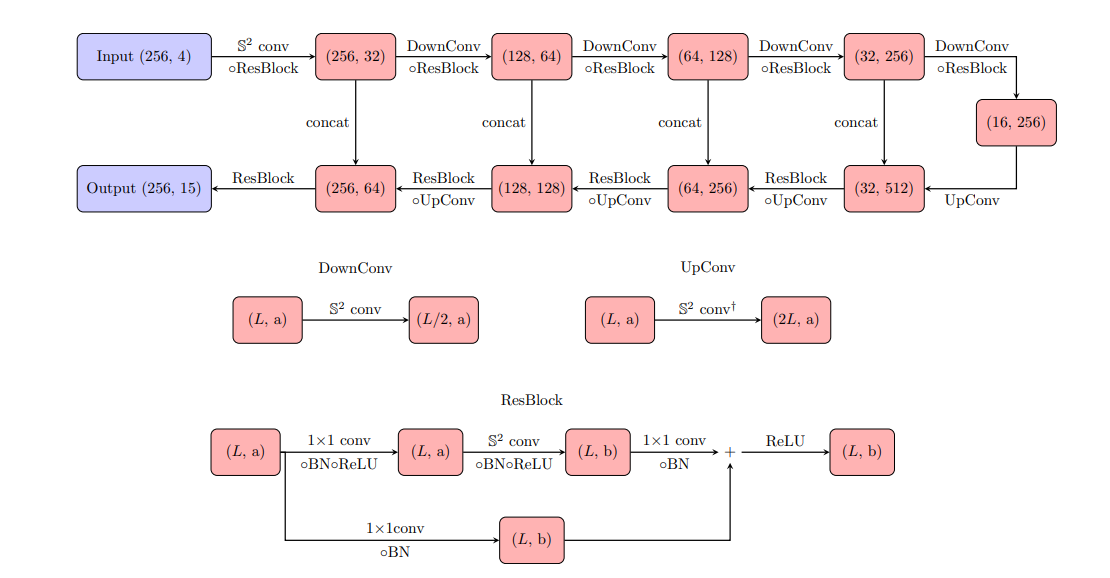

The architecture consists of convolutional blocks (scaling the resolution) followed by residual blocks (changing the number of channels). 

Let us first look at the architecture currently employed. See `model.py` for more detail.

In [ ]:
# S2_UNET Model Architecture visualisation
print("Loading S2_UNET Model Architecture")
print("=" * 50)

# Initialise random number generator for model creation
rngs = nnx.Rngs(42)

# Create model instance with custom channel configuration
print("Creating S2_UNET model instance...")
print(f"Using channel configuration: {chs_dummy}")
model = S2_UNET(
    L=L,  # Use actual L value from parameters
    ch_in=len(frequencies),  # Number of input frequency channels
    chs=chs_dummy,  # Use simple channel configuration for dummy model
    rngs=rngs,
)

print(f"Model created successfully!")
print(f"Input channels: {len(frequencies)} (frequencies: {frequencies})")
print(f"Output channels: 1 (CMB residual correction)")
print(f"Spherical resolution: L = {L} (lmax = {desired_lmax})")
print(f"Channel progression: {chs_dummy}")

# Get model structure using JAX/Flax introspection
print(f"\n" + "=" * 50)
print("MODEL ARCHITECTURE SUMMARY")
print("=" * 50)


# Use JAX to create model summary
def count_parameters(model):
    """Count trainable parameters in the model."""
    # Get the model state which contains all parameters
    graphdef, state = nnx.split(model)
    
    # Count parameters using JAX tree utilities
    total_params = 0
    
    # Use JAX tree_leaves to get all parameter arrays
    param_arrays = jax.tree_util.tree_leaves(state)
    
    for param in param_arrays:
        if hasattr(param, 'shape') and hasattr(param, 'size'):
            # This is a parameter array
            total_params += param.size
        elif hasattr(param, 'shape'):
            # Fallback: calculate size from shape
            total_params += np.prod(param.shape)
    
    return total_params, total_params  # Return same for both total and trainable

total_params, trainable_params = count_parameters(model)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Parameter memory (32-bit): {total_params * 4 / 1024**2:.1f} MB")
print(f"\nNote: This is a simplified model with channels {chs_dummy}")
print(f"Default production model uses channels [1, 16, 32, 32, 64] with ~{trainable_params*16:.0f} parameters")

# Display model structure using string representation
print(f"\n" + "-" * 40)
print("MODEL STRUCTURE OVERVIEW")
print("-" * 40)

# Get a readable model structure
model_repr = repr(model)
print(model_repr)
lines = model_repr.split('\n')
print('\n'.join(lines[:30]))

# Memory cleanup
del rngs, model_repr, lines
del total_params, trainable_params
import gc
gc.collect()

## Training Example on Dummy data

Now, we will show the training pipeline, using `data.py` and `train.py`. Since we are working with a small training/test set, the model will not train well, but the key point is to demonstrate the workflow. 


In [ ]:
# Training with Custom Channel Configuration
# Using simple channel configuration for fast dummy training

trainer = Train(
    frequencies=frequencies,
    realisations=realisations,
    lmax=desired_lmax,
    N_directions=N_directions,
    lam=lam,
    batch_size=batch_size,
    epochs=epochs,
    learning_rate=lr,
    momentum=momentum,
    chs=chs_dummy,  # Use simple channel configuration for fast training
    directory=data_directory,
)

trainer.execute_training_procedure()

# Memory cleanup
del trainer
import gc
gc.collect()

## Loading pre-trained models for inference

In `...` you will find some `orbax` model checkpoints that can be used to load a pre-trained model based on 1000 realisations, 3 frequencies and $L=512$. This was used during the testing stage for the ML pipeline. In this section, we will generate a single realisation for the model to be applied to, then load the model and perform inference using `inference.py` to create an improved ILC power spectrum.

**Note:** This part of the notebook is WIP, see comment in second cell below.

In [ ]:
# Generate Data for Pre-trained model inference
# Parameters from the pre-trained model training command
pretrained_frequencies = ["030", "100", "353"]
pretrained_realisations = 1  # Just one realisation for demonstration
pretrained_start_realisation = 0
pretrained_lmax = 511
pretrained_lam = 2.0
pretrained_N_directions = 1
# Pre-trained model uses default channel configuration: [1, 16, 32, 32, 64]
chs_pretrained = None  # Use default channels for pre-trained model

print("Running SILC Pipeline for Pre-trained Model Parameters")

# Run SILC pipeline with pre-trained model parameters
print(f"\nRunning SILC pipeline to generate pre-trained-model-compatible data...")

pipeline_pretrained = Pipeline(
    components=["cmb", "sync", "dust", "noise"],
    wavelet_components=["cfn"],
    ilc_components=["cfn"], 
    frequencies=pretrained_frequencies,
    realisations=pretrained_realisations,
    start_realisation=pretrained_start_realisation,
    lmax=pretrained_lmax,
    N_directions=pretrained_N_directions,
    lam=pretrained_lam,
    method="jax_cuda",
    visualise=False,
    save_ilc_intermediates=False,
    overwrite=True,  # Overwrite to ensure fresh data
    directory=data_directory,
)
pipeline_pretrained.run()
print("SILC pipeline completed for pre-trained model parameters!")

# Memory cleanup 
del pipeline_pretrained
import gc
gc.collect()

In [ ]:
## NOTE: To run this cell, you will need to obtain a trained model using train.py. 
# Place the checkpoint file in your /data/ML/models and change model path
# Did not have time to add model to directory. 

model_path = "/path/to/model"


# Apply predict_cmb to realisation 0 and visualise improved ILC power spectrum

print("Complete ML Inference Application and Visualieation")
print("=" * 60)

# Import the Inference class and visualisation tools
from skyclean.ml.inference import Inference
from skyclean.silc.visualise import Visualise

# Initialise inference system with pre-trained model parameters
print("Initialising inference system...")
inference = Inference(
    frequencies=pretrained_frequencies,
    realisations=pretrained_realisations,  # Use the single realisation we generated
    lmax=pretrained_lmax,
    N_directions=pretrained_N_directions,
    lam=pretrained_lam,
    chs=chs_pretrained, 
    directory=data_directory,
    model_path=model_path
)

# Load the model
model = inference.load_model(force_load=True)  

if model:
    # Apply inference to realisation 0
    print(f"\nApplying ML inference to realisation 0...")
    cmb_improved = inference.predict_cmb(realisation=0, save_result=True)
    
    # visualise power spectra including improved ILC
    print(f"\nCreating power spectrum visualisations...")
    visualiser = Visualise(
        frequencies=pretrained_frequencies,
        realisation=0,
        lmax=pretrained_lmax,
        lam_list=[pretrained_lam],
        directory=data_directory
    )

    visualiser.visualise_power_spectra(["cmb", "ilc_synth", "ilc_improved"])
